# Treinamento Sentimento


In [1]:
import warnings

# Ignorar todos os warnings
warnings.filterwarnings("ignore")

import nltk

# Abre o menu interativo do NLTK Downloader
# nltk.download()

import tensorflow as tf

tf.random.set_seed(5)
import io
from tensorflow.keras.utils import get_custom_objects
import numpy as np
import pandas as pd
import gensim # use 3.8.3
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
import pickle
from datetime import date 
import time
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.metrics import precision_score, recall_score, classification_report

## Etapa 1: Carregamento da base de dados gerado pelo preprocessamento

In [2]:
data_hora = date.today().strftime("%d_%m_%Y")
print(data_hora)
# data_hora = '18_08_2024'

path_bases = 'dataset/'
df_full = pd.read_parquet(f"{path_bases}train_process.parquet")

base_dados = df_full.sample(frac=1).reset_index(drop=True)

26_12_2024


In [3]:
base_dados.head()

,texto,sentimento,texto_preprocess
0,"“Todo mundo quieto até a eleição”, diz Bolsona...",neutro,“ mundo quietar o eleição ” bolsonaro o equipa...
1,Aguardando a chuva :),positivo,aguardar o chuva emocaopositiva
2,&gt;@EstadaoLink Hacker aproveita falha da App...,neutro,gt hacker aproveitar falho apple e comprar i...
3,@martinha0503 @_carolinacosta6 Eu amo-vos as d...,positivo,amo-vos o emocaopositiva
4,Soh queria receber um boa noite fofinho p dorm...,negativo,soh querer receber noite fofo p dormir emocaon...


In [4]:
categoria = base_dados.groupby(['sentimento']).sentimento.count()
categoria

sentimento
negativo    32331
neutro      31556
positivo    32634
Name: sentimento, dtype: int64

## Pre processamento

In [5]:
base_dados['texto_preprocess'] = base_dados['texto_preprocess'].astype(str)
base_dados['texto_preprocess'] = base_dados.texto_preprocess.replace('',np.nan,regex = True)

## Criar a lista de sentenças

In [6]:
stopwords = nltk.corpus.stopwords.words("portuguese")

sent_lst = []

for doc in tqdm(base_dados['texto_preprocess'].values):
    sentences = nltk.tokenize.sent_tokenize(doc, language ="portuguese")

    for sent in sentences:
        words_lst = [w.lower() for w in nltk.tokenize.word_tokenize(sent, language="portuguese") \
                        if w.isalnum() and w not in stopwords]
        sent_lst.append(words_lst)

100%|██████████| 96521/96521 [00:09<00:00, 10262.67it/s]


## Criando o Word Embeddings usando o FastText

In [9]:
from gensim.models import FastText

# Dados de exemplo (lista de listas de palavras)
sentences = [["gato", "branco"], ["cachorro", "preto"], ["gato", "preto"]]

# Treinando o modelo FastText
model = FastText(sentences, size=100, window=5, min_count=1, sg=1)

# Obtendo o vetor de uma palavra
print(model.wv['gato'])


[ 8.5976120e-04  2.5745120e-03 -3.6583579e-04 -1.8020771e-03
  9.7642449e-04 -1.0324823e-03 -4.3620943e-04  3.1434423e-03
 -6.3821540e-04 -4.5099034e-04  4.2857966e-04 -8.8973809e-04
 -2.9042840e-03  1.1222657e-03  9.5399114e-04 -9.0067455e-04
  2.0341922e-03  7.5925363e-04  2.8954088e-03  5.6714780e-04
 -2.6573875e-04  4.9230563e-03 -2.3991456e-03 -2.8371909e-03
  3.4358653e-03  2.0234610e-03  2.2880631e-03 -1.4855477e-03
 -5.2846459e-05 -1.7933476e-04 -8.4771361e-04 -1.3085201e-03
  4.5429971e-03  6.1689108e-04  1.1746975e-03 -1.4843912e-03
  3.0445433e-03  9.8392600e-04 -3.3049306e-04  2.7927859e-03
  8.2579139e-04 -6.4389122e-04 -8.1106462e-04  3.9706202e-04
 -6.0533412e-04 -3.6340163e-04 -3.2218630e-04  1.6595270e-03
  1.5759621e-03 -4.5236517e-03 -2.8517231e-04  2.2719859e-03
  4.1194886e-04 -1.6126278e-04  1.0128760e-03 -2.9825044e-03
 -2.2577993e-03 -3.5923830e-04  3.4877271e-03  8.7907776e-04
 -2.1690472e-03  2.1922283e-03  5.8171997e-04 -1.2957922e-03
 -7.0504431e-04 -7.64016

In [10]:
path_modelos = 'modelos'

filename = f'{path_modelos}/{data_hora}/fasttext/fasttext_model.txt'
print(filename)

modelos/26_12_2024/fasttext/fasttext_model.txt


In [11]:
embed_dim = 100
embed_size = 100
max_features = 3000
maxlen = 100

In [12]:
inicio = time.time()

fasttext_model = gensim.models.FastText(size=embed_dim, window=1)
fasttext_model.build_vocab(sentences=sent_lst)
fasttext_model.train(sentences =sent_lst, total_examples=len(sent_lst), epochs=100)
fim = time.time()
print('Tempo para embedding: ',(fim - inicio)/60)

Tempo para embedding:  2.0267305811246237


In [13]:
fasttext_model.save(filename)

## Tokenização

In [14]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(base_dados['texto_preprocess'].values)

In [15]:
onehot_encoder = OneHotEncoder(sparse=False)
y = base_dados['sentimento'].values
y = y.reshape(-1,1)
y_encoder = onehot_encoder.fit_transform(y)


tokenx = tokenizer.texts_to_sequences(base_dados['texto_preprocess'])

## Padding

In [16]:
pad_x = pad_sequences(tokenx, maxlen=maxlen)

## Separar treinamento e teste para avaliação

In [17]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(pad_x,
                                                                        y_encoder,
                                                                        test_size=0.2,
                                                                        stratify = y_encoder)

## Ler o modelo embedding criado

In [18]:
embedding_index = fasttext_model.wv

embedding_matrix = np.zeros(( len(tokenizer.word_index), embed_size))

for word, i in tqdm(tokenizer.word_index.items()):
    try:
        embedding_vector = embedding_index[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except Exception as e:
        continue

100%|██████████| 45837/45837 [00:01<00:00, 37329.33it/s] 


In [19]:
embedding_matrix.shape

(45837, 100)

In [20]:
vocabulary_size = len(tokenizer.word_index)
categoria = base_dados.groupby(['sentimento']).sentimento.count()
num_classes = len(categoria)

print('Tamanho do vocaulário', vocabulary_size)
print('Número de classes', num_classes)

Tamanho do vocaulário 45837
Número de classes 3


## Criando uma função de ativação

In [21]:
class GeluActivation(layers.Activation):
    def __init__(self, activation, **kwargs):
        super(GeluActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'gelu'

    def get_config(self):
        config = super(GeluActivation, self).get_config()
        return config

        
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2/np.pi) * (x + 0.044715 * tf.pow(x,3)) ))

get_custom_objects().update({'gelu' : GeluActivation(gelu)})

## Criando a camada de atenção

In [73]:
# class Attention(layers.Layer):
#     def __init__(self, attention_dim=50, **kwargs):
#         self.init = tf.keras.initializers.get('normal')
#         self.attention_dim = attention_dim
        
#         super(Attention, self).__init__(**kwargs)
    
#     def build(self, input_shape):
#         self.W = K.variable(self.init((input_shape[-1],1)))
#         self.b = K.variable(self.init((self.attention_dim, )))
#         self.u = K.variable(self.init((self.attention_dim, 1)))
        
#         super(Attention, self).build(input_shape)
#     def call(self, x):
#         ui = K.tanh(K.bias_add(K.dot(x,self.W), self.b))
#         dot = K.squeeze(K.dot(ui, self.u), -1)
        
#         attention_weights = tf.nn.softmax(dot, axis=1)
#         attention_weights = K.expand_dims(attention_weights)
        
#         context_vector = attention_weights * x
#         context_vector = K.sum(context_vector, axis=1)
        
#         return context_vector
        
    
#     def get_config(self):
#         return {'attention_dim' : self.attention_dim}

class Attention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
            name="attention_weight"
        )
        self.b = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
            name="attention_bias"
        )
        self.u = self.add_weight(
            shape=(self.units, 1),
            initializer="random_normal",
            trainable=True,
            name="attention_score"
        )

    def call(self, inputs):
        ui = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        scores = tf.nn.softmax(tf.squeeze(tf.matmul(ui, self.u), axis=-1), axis=1)
        context = tf.reduce_sum(inputs * tf.expand_dims(scores, -1), axis=1)
        return context

    def get_config(self):
        config = super(Attention, self).get_config()
        config.update({
            "units": self.units
        })
        return config



## Montando a arquiteturra

In [75]:
inp = layers.Input(shape=(maxlen,))

x = layers.Embedding(
    vocabulary_size, 
    embed_size,
    weights=[embedding_matrix],
    input_length=maxlen,
    trainable=True, name="embedding_layer"
    )(inp)

dropout = layers.Dropout(0.1)(x)

x = layers.Bidirectional(layers.LSTM(40,
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                     recurrent_regularizer=tf.keras.regularizers.l2(0.001),
                                     return_sequences=True
                                     ))(dropout)
y = layers.Bidirectional(layers.GRU(40,
                                    kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                    recurrent_regularizer=tf.keras.regularizers.l2(0.001),
                                    return_sequences=True
                                    ))(dropout)

atten_l = Attention(50, name="Attention_LSTM") (x)
atten_2 = Attention(50, name="Attention_GRU") (y)

x = layers.concatenate([atten_l,atten_2])



x = layers.Dense(16, activation=gelu,
                 kernel_regularizer=tf.keras.regularizers.l2(0.001)
                 )(x)
x = layers.Activation('gelu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Flatten()(x)

outp = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=inp, outputs=outp)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

## Mostrando Arquitetura

In [76]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_layer (Embedding)    (None, 100, 100)     4583700     ['input_7[0][0]']                
                                                                                                  
 dropout_12 (Dropout)           (None, 100, 100)     0           ['embedding_layer[0][0]']        
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 100, 80)     45120       ['dropout_12[0][0]']             
 l)                                                                                         

In [ ]:
# plot_model(model, to_file=f'modelos/model_plot+{data_hora}.png', show_shapes=True, show_layer_names=True)

## Checkpoint do Modelo

In [77]:
filepath = f"{path_modelos}/{data_hora}/weights/checkpoint.ckpt"
print(filepath)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor="val_categorical_accuracy",
                                                verbose=1,
                                                save_best_only=True,
                                                save_weights_only=True,
                                                mode='max')

reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_categorical_accuracy",
                                                              factor=0.1, # new_lr = lr * 0.1
                                                              verbose=1,
                                                              mode = 'max',
                                                              min_lr = 0.001,
                                                              patience=4
                                                              )

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', 
                                                  patience=20,
                                                  verbose=1,
                                                  mode='max')

modelos/26_12_2024/weights/checkpoint.ckpt


In [78]:
# Carregue os pesos treinados
model.load_weights(filepath)

## Treinando arquitetura

In [60]:
num_epocas = 100
inicio = time.time()
hist = model.fit(train_inputs, train_labels, batch_size = 255,
                 epochs = num_epocas, validation_data=(test_inputs, test_labels),
                 callbacks = [checkpoint, reduce_lr_on_plateau, early_stopping],
                 verbose = 1)
fim = time.time()
print('Tempo de treinamento: ',(fim - inicio)/60)

Epoch 1/100
302/303 [============================>.] - ETA: 0s - loss: 0.5721 - categorical_accuracy: 0.8448
Epoch 1: val_categorical_accuracy improved from -inf to 0.96664, saving model to modelos/26_12_2024/weights\checkpoint.ckpt
303/303 [==============================] - 21s 51ms/step - loss: 0.5712 - categorical_accuracy: 0.8451 - val_loss: 0.2036 - val_categorical_accuracy: 0.9666 - lr: 0.0010
Epoch 2/100
302/303 [============================>.] - ETA: 0s - loss: 0.1821 - categorical_accuracy: 0.9672
Epoch 2: val_categorical_accuracy improved from 0.96664 to 0.97110, saving model to modelos/26_12_2024/weights\checkpoint.ckpt
303/303 [==============================] - 14s 46ms/step - loss: 0.1820 - categorical_accuracy: 0.9672 - val_loss: 0.1477 - val_categorical_accuracy: 0.9711 - lr: 0.0010
Epoch 3/100
302/303 [============================>.] - ETA: 0s - loss: 0.1403 - categorical_accuracy: 0.9718
Epoch 3: val_categorical_accuracy improved from 0.97110 to 0.97291, saving model t

## Plotando os resultados

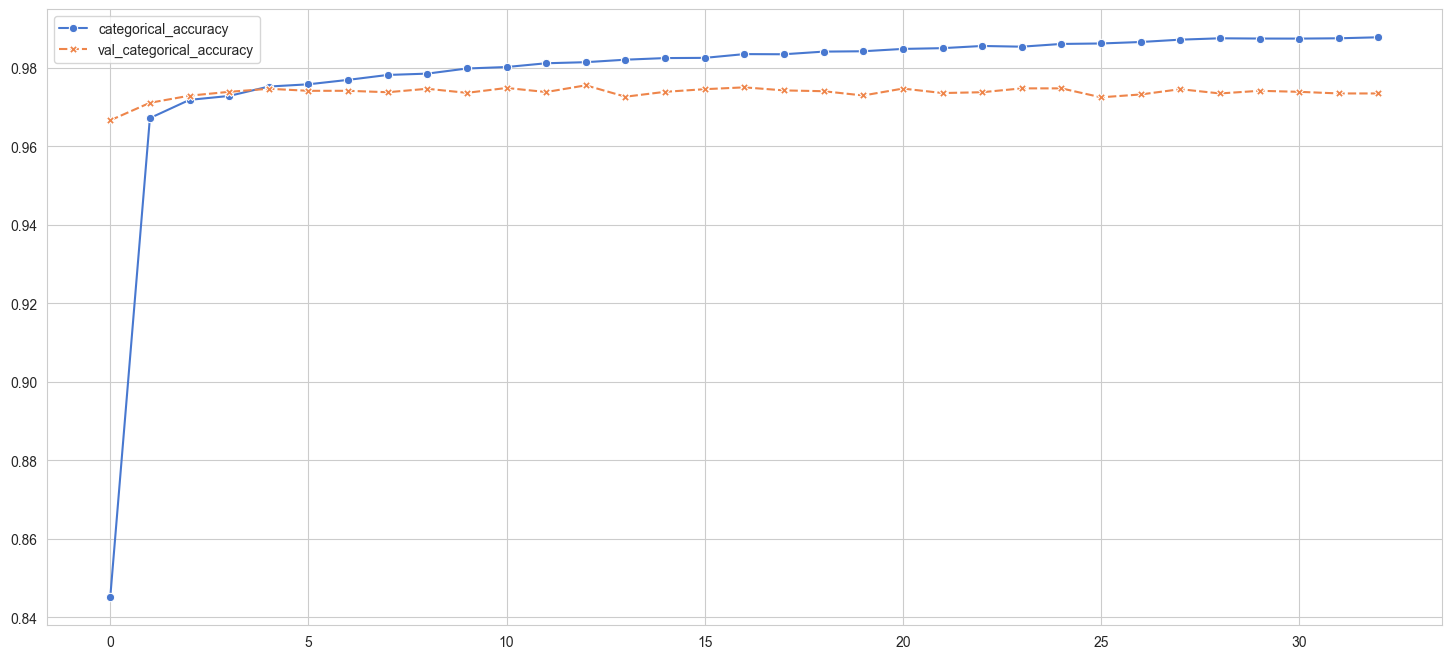

In [63]:
sns.set_style("whitegrid")
metrics_df_acc = pd.DataFrame(
    {
         "categorical_accuracy": hist.history['categorical_accuracy'],
         "val_categorical_accuracy" : hist.history['val_categorical_accuracy']
     }
)
plt.figure(figsize=(18,8))
ax = sns.lineplot(data=metrics_df_acc, palette="muted",markers=True)

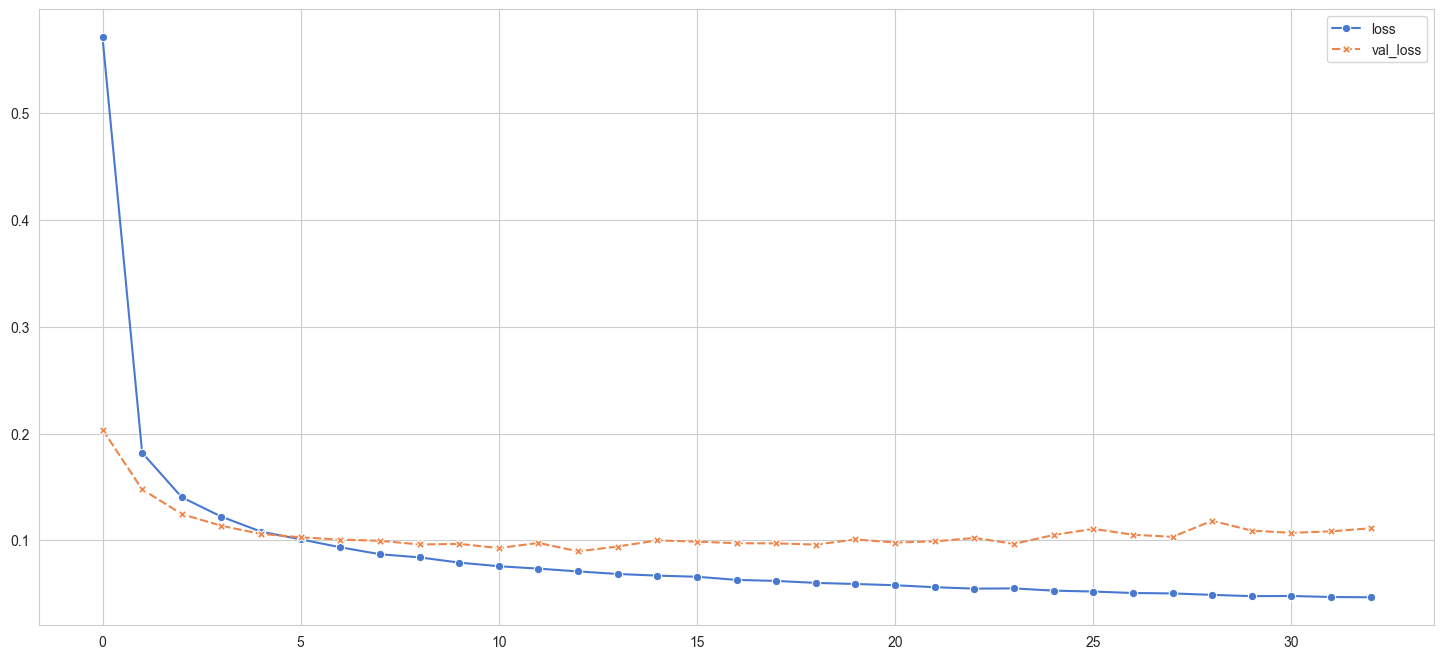

In [64]:
metrics_df_loss = pd.DataFrame(
    {
         "loss" : hist.history['loss'],
         "val_loss" : hist.history['val_loss']
     }
)
plt.figure(figsize=(18,8))
ax = sns.lineplot(data=metrics_df_loss, palette="muted",markers=True)

## Salvando o modelo

In [79]:
model.save("modelo_atencao.h5")


In [65]:
    
# salvando o vacabolário
with open(f"{path_modelos}/{data_hora}/tokenizer.pickle","wb") as file_handle:
    pickle.dump(tokenizer, file_handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# teste para um texto
categorias = list(onehot_encoder.categories_[0])

# salvando as categorias
with open(f"{path_modelos}/{data_hora}/categorias.pickle","wb") as file_handle:
    pickle.dump(categorias, file_handle, protocol=pickle.HIGHEST_PROTOCOL)

## Avaliando o modelo base de teste

In [87]:
from tensorflow.keras.models import load_model

# Registrar objetos personalizados
custom_objects = {
    "Attention": Attention,          # Classe de atenção
    "GeluActivation": GeluActivation # Função de ativação personalizada
}

# Carregar o modelo
modelo_carregado = load_model("modelo_atencao.h5", custom_objects=custom_objects)

# Exibir o resumo do modelo carregado
modelo_carregado.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_layer (Embedding)    (None, 100, 100)     4583700     ['input_7[0][0]']                
                                                                                                  
 dropout_12 (Dropout)           (None, 100, 100)     0           ['embedding_layer[0][0]']        
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 100, 80)     45120       ['dropout_12[0][0]']             
 l)                                                                                         

In [88]:
text_to_predict = modelo_carregado.predict(test_inputs, batch_size=100)

predict_label = []
for index in text_to_predict:
    #print(index) 
    predict_label.append(np.argmax(index))
    
real_label = []
for index in test_labels:
    #print(index) 
    real_label.append(np.argmax(index))
            
acuracia = accuracy_score(predict_label, real_label)
print('Acurácia', acuracia)
precision = precision_score(predict_label, real_label, average='micro')
print('Precision', precision)
recall = recall_score(predict_label, real_label, average='micro')
print('Recall', recall)

194/194 [==============================] - 5s 19ms/step
Acurácia 0.9755503755503756
Precision 0.9755503755503756
Recall 0.9755503755503756


In [67]:
print(classification_report(predict_label, real_label, target_names=['negativo', 'positivo', 'neutro']))

              precision    recall  f1-score   support

    negativo       0.98      0.99      0.98      6370
    positivo       0.97      0.97      0.97      6321
      neutro       0.97      0.96      0.96      6614

    accuracy                           0.97     19305
   macro avg       0.97      0.97      0.97     19305
weighted avg       0.97      0.97      0.97     19305



## Avaliando o modelo toda a base

In [89]:
text_to_predict = modelo_carregado.predict(pad_x, batch_size=100)
predict_label = []
for index in text_to_predict:
    #print(index) 
    predict_label.append(np.argmax(index))
    
real_label = []
for index in y_encoder:
    #print(index) 
    real_label.append(np.argmax(index))
            
acuracia = accuracy_score(predict_label, real_label)
print('Acurácia', acuracia)
precision = precision_score(predict_label, real_label, average='micro')
print('Precision', precision)
recall = recall_score(predict_label, real_label, average='micro')
print('Recall', recall)

966/966 [==============================] - 14s 15ms/step
Acurácia 0.9835476217610676
Precision 0.9835476217610676
Recall 0.9835476217610676


In [90]:
previsoes = [categorias[idx] for idx in predict_label]
classes = base_dados['sentimento'].values.tolist()

In [91]:
report = classification_report(classes, previsoes, target_names=['negativo', 'positivo', 'neutro'])
print(report)

              precision    recall  f1-score   support

    negativo       1.00      0.98      0.99     32331
    positivo       0.99      0.99      0.99     31556
      neutro       0.97      0.99      0.98     32634

    accuracy                           0.98     96521
   macro avg       0.98      0.98      0.98     96521
weighted avg       0.98      0.98      0.98     96521



In [92]:
nome_arquivo = "relatorio_classificacao.txt"

with open(nome_arquivo, 'w', encoding='utf-8') as arquivo:
    print(report, file=arquivo)

print("Relatório de classificação salvo com sucesso em", nome_arquivo)

Relatório de classificação salvo com sucesso em relatorio_classificacao.txt
